# Jax for robot learning: an introduction

|| | |
| :---: | :---: | :---: |
| Artificial Mechanical Intelligence @ IIT | Diego Ferigo | 2023/04/13 | 

During this series of presentations, people often presented worked performed in the past, highlighting methods and results achieved so far.
This presentation is centered on methods I've used during my PhD, but this time it is forward looking. It will not present achieved results but rather provide an overview on methods that I believe can simplify the life of researchers working on the boundary between robotics and machine learning.

In AMI, recently we have been embracing more and more the robot learning paradigm, and I believe that we have room of improvement about how we approach and prototype novel applications. So far, we often choose to rely on existing solutions that are not necessarily designed to be used within a robot learning architecture, obtaining suboptimal performance and possibly limiting the formulation of novel solutions to the problems at hand.

Here below a summary of this notebook's content:

- Quick introduction on JAX;
- Quick introduction on PyTrees;
- Modelling of pendulum dynamics using 6D quantities;
- Application 1: develop a simple rigid-body simulator to compute trajectories;
- Application 2: consider the simulated trajectories as a dataset sampled from a real pendulum, and use the physical equations of motion as feed-forward model to create a hardware optimization pipeline that learns the (assumed unknown) mechanical parameters of the real pendulum.

## Table of Contents

* [1. What is JAX](#1.-What-is-JAX)
  * [Notebook initialization](#Notebook-initialization)
  * [What is a PyTree](#What-is-a-PyTree)
  * [How to use the JIT compiler](#How-to-use-the-JIT-compiler)
* [2. Advanced system modelling: 6D dynamics of a pendulum system](#2.-Advanced-system-modelling:-6D-dynamics-of-a-pendulum-system)
  * [Notation](#Notation)
  * [Equations of Motion](#Equations-of-Motion)
  * [State-space representation of the system dynamics (1/2)](#State-space-representation-of-the-system-dynamics-(1/2))
  * [State-space representation of the system dynamics (2/2)](#State-space-representation-of-the-system-dynamics-(2/2))
  * [ODE integration](#ODE-Integration)
* [3. Application 1: sample simulated trajectories](#3.-Application-1:-sample-simulated-trajectories)
* [4. Application 2: hardware optimization](#4.-Application-2:-hardware-optimization)
* [Final thoughts](#Final-thoughts)
* [Additional resources](#Additional-resources)

## 1. What is JAX

JAX is a framework exposing a [NumPy](https://numpy.org/)-compatible APIs.

<img src="https://user-images.githubusercontent.com/469199/231703935-da5ecebc-778a-4419-8ee4-f208e4506911.svg" width="40%">
                                                    
Benefits:

- Prototyping is easy: familiar APIs and rapid idea-to-implementation process thanks to Python.
- Speeding up computation is possible: code properly structured can be compiled to machine code in just-in-time (JIT) with `jax.jit`.
- Write code once, run it on CPUs / GPUs / TPUs thanks to XLA.
- Write parallel algorithms as a data flow operating on a single element, and seamlessly run it concurrently by transforming it with `jax.vmap` (no need to learn CUDA kernels).
- Write code operating on heterogeous data structures thanks to `PyTree` generalization.
- All implemented APIs support automatic differentiation (AD) that can be used for scientific programming (not only ML!).
- Excellent debugging capability:
  - [NaNs detection](https://jax.readthedocs.io/en/latest/debugging/flags.html),
  - [`jax.debug.print`](https://jax.readthedocs.io/en/latest/debugging/print_breakpoint.html) inside compiled code,
  - [`jax.experimental.host_callback`](https://jax.readthedocs.io/en/latest/jax.experimental.host_callback.html) inside compiled code.

Limitations:

- JAX is a new framework and although the ecosystem is growing, is not as popular as PyTorch.
- Code transformed with `jit` and `vmap` must be developed entirely in JAX, in most cases you cannot use third-party libraries.
- Branching and looping is supported (`if`, `for,`, `while`, etc.) but low-level [`jax.lax`](https://jax.readthedocs.io/en/latest/jax.lax.html#control-flow-operators) calls have to be used.
- When dealing with physics equations, 64 bit support has to be enabled.

---

* https://jax.readthedocs.io/en/latest/glossary.html
* https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
* https://jax.readthedocs.io/en/latest/jax-101/index.html
* https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html
* https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html


### Notebook initialization

In [3]:
import jax.config
import jax.numpy as jnp

# Uncomment this line to enforce using the CPU
jax.config.update('jax_platform_name', 'cpu')

print(f"JAX is running on device: {jnp.zeros(0).device()}")

JAX is running on device: TFRT_CPU_0


In [4]:
import warnings
from typing import Dict, Union, Tuple

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # always enable 64bit when dealing with physics
jnp.set_printoptions(precision=5, suppress=True, linewidth=150, threshold=10_000)
warnings.simplefilter(action="ignore", category=FutureWarning)

import dataclasses
import functools
from typing import Any, Callable, Generic, TypeVar

import diffrax
import jax.test_util
import jax_dataclasses
import matplotlib.pyplot as plt
import numpy.typing as npt
import optax
from IPython.display import Markdown, display
from jaxlie import SE3, SO3


class Operators:
    """Scope for useful operators used in this script."""

    @staticmethod
    def hat(vector: jnp.ndarray) -> jnp.ndarray:
        """Return the (skew-symmetric) matrix operator of the cross product in ℝ³."""

        x, y, z = vector.squeeze()

        return jnp.array(
            [
                [0, -z, y],
                [z, 0, -x],
                [-y, x, 0],
            ],
        )

    @staticmethod
    def cross(velocity: jnp.ndarray) -> jnp.ndarray:
        """Return the matrix operator of the cross product in ℝ⁶."""

        v, ω = jnp.split(velocity.squeeze(), 2)

        return jnp.block(
            [
                [Operators.hat(ω), Operators.hat(v)],
                [jnp.zeros(shape=(3, 3)), Operators.hat(ω)],
            ]
        )

    @staticmethod
    def cross_star(velocity: jnp.ndarray) -> jnp.ndarray:
        """Return the matrix operator of the dual cross product in ℝ⁶."""

        v, ω = jnp.split(velocity.squeeze(), 2)

        return jnp.block(
            [
                [Operators.hat(ω), jnp.zeros(shape=(3, 3))],
                [Operators.hat(v), Operators.hat(ω)],
            ]
        )

### What is a PyTree

PyTrees are a generalization of (possibly nested) Python containers.

JAX allows to write generic functions that operate on eterogeneous data structures by providing operators on PyTree objects.

---

- https://jax.readthedocs.io/en/latest/pytrees.html
- https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html

In [5]:
def mean_squared_error(pytree_true: Any, pytree_pred: Any) -> float:
    """Compute the mean-squared error between two PyTrees."""

    # Compute a new pytree having as leafs the squared error of the
    # leafs of the input pytrees
    squared_error_tree = jax.tree_util.tree_map(
        lambda leaf_true, leaf_pred: (leaf_true - leaf_pred) ** 2,
        pytree_true,
        pytree_pred,
    )
    
    # Flatten the tree to have a list of leaves
    squared_error_flat_list, _ = jax.tree_util.tree_flatten(squared_error_tree)
    
    # Compute and sum together the mean squared error of all leaves
    return jnp.array(
            [jnp.array(squared_error).mean() for squared_error in squared_error_flat_list]
        ).mean()


# ========
# Examples
# ========

# Scalars
print(mean_squared_error(0, 1))

# Arrays
print(mean_squared_error(jnp.array([1, 2, 3]), jnp.array([-1, -2, -3])))

# Dictionaries
print(mean_squared_error(dict(a=1, b=2, c=3), dict(a=-1, b=-2, c=-3)))

# Tuples
print(mean_squared_error((1, 2, 3), (-1, -2, -3)))

1.0
18.666666666666664
18.666666666666664
18.666666666666664


### How to use the JIT compiler

In [6]:
# ===============
# JIT compilation
# ===============

big_pytree_a = {
    "first": jnp.zeros(shape=(1_000, 1_000)),
    "second": jnp.zeros(shape=(10_000, 10_000)),
}

big_pytree_b = {
    "first": jnp.ones(shape=(1_000, 1_000)),
    "second": jnp.ones(shape=(10_000, 10_000)),
}

# This will take a lot of time ~0.5s
%timeit mean_squared_error(big_pytree_a, big_pytree_b)

# Let's JIT compile it and benchmark the compilation time
mean_squared_error_jit = jax.jit(mean_squared_error)
%timeit -r1 -n1 mean_squared_error_jit(big_pytree_a, big_pytree_b)

# Let's benchmark the compiled function
%timeit mean_squared_error_jit(big_pytree_a, big_pytree_b)

# Note: this is a simple example and we only got a 3x performance.
# It's common to have improvements of order of magnitude for more complex computations. 

785 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
306 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
224 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Advanced system modelling: 6D dynamics of a pendulum system

To describe how JAX can be used for robot learning applications, we consider a canonical example in robot control: the pendulum.

You can find [existing tutorials](http://adria.fesb.hr/~alojic00/blog/Pendulum%20inverse%20identification%20with%20JAX.html) that consider the most basic form of this system. It is a great start, but for practical application that might be interesting for out activities, the step from such simple examples to our use-case might be too wide for beginners.

This section will show you how the same pendulum system can be modelled and simulated using 6D algebra. We consider the pendulum as a free-floating rigid body subject to holonomic constraint that will limit its motion such that it can only swing around a predefined pivot point.

We describe the pendulum as a cylindrical body as illustrated in the picture below, parameterized with the following quantities:

- Total mass $m$
- Length of the cylinder $l$
- Radius of the cylinder $r$
- Viscous friction at the pivot point $k_v$

<img src="https://user-images.githubusercontent.com/469199/231703711-cbfdd7a1-904d-4fe9-9efd-e1e19cf7490d.png" width="80%">

### Notation

Refer to Traversaro and Saccon <a name="traversaro_multibody_2019"></a>[<sup>[1]</sup>](#traversaro_multibody_2019_cite) for more details on the notation. The table below reports the most important symbols used in this notebook.

|               Symbol               |            Space            |                                 Description                                  |
|:----------------------------------:|:---------------------------:|:-----------------------------------------------------------------------------|
|            $\mathbb{M}$            |  $\mathbb{R}^{6 \times 6}$  |                              6D inertia matrix                               |
|         ${}^W \mathbf{g}$          |      $\mathbb{R}^3$         |                     Gravity vector in world coordinates                      |
|        ${}^A \mathbf{R}_B$         |           SO($3$)           |                  Rotation matrix between frames $A$ and $B$                  |
|        ${}^A \mathbf{H}_B$         |           SE($3$)           |                     Trasform between frames $A$ and $B$                      |
|        ${}^A \mathbf{X}_B$         |  $\mathbb{R}^{6 \times 6}$  |            Transform for 6D velocities between frames $A$ and $B$            |
|        $\mathbf{v}_{A,B}$         |       $\mathbb{R}^6$        |                    6D velocity between frames $A$ and $B$                    |
|     $\dot{\mathbf{v}}_{A,B}$      |       $\mathbb{R}^6$        |                  6D acceleration between frames $A$ and $B$                  |
|         ${}_A \mathbf{f}$          |       $\mathbb{R}^6$        |  6D force applied to a given point with coordinates expressed in frame $A$   |
|   $ \mathbf{v}_{A,B} \times$       |  $\mathbb{R}^{6 \times 6}$  |         Matrix representation of the cross product in $\mathbb{R}^6$         |
| $ \mathbf{v}_{A,B} \bar{\times}^*$ | $ \mathbb{R}^{6 \times 6} $ |      Matrix representation of the dual cross product in $\mathbb{R}^6$       |

### Equations of Motion

We consider two frames:

- A world frame $W$ defines the pivot point of the pendulum;
- A body frame $B$ rigidly attached to the pendulum defines its pose.

Depending on the need, we might express the body velocity $\mathbf{v}_{W,B}$ either:

- in inertial-fixed representation denoted as ${}^W \mathbf{v}_{W,B}$;
- in body-fixed representation denoted as ${}^B \mathbf{v}_{W,B}$.

We describe the pendulum as a generic rigid body whose pose is defined by a frame $B$ rigidly attached, and a holonomic constraint at the origin of the world frame $W$ that only allows rotating around the $x$ axis ($\omega_x$).
The equations of motion of the system are the following, where the first is the Euler-Poincaré equation expressed in $B$ coordinates, and the second is the holonomic constraint:

$$
\begin{cases}
    \mathbb{M} {}^B \dot{\mathbf{v}}_{W, B} + {}^B \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} = \mathbb{M} \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + {}_B \mathbf{f}_{\text{ext}} \\
    J_c {}^B \mathbf{v}_{W, B} = [{}^W v_x,\, {}^W v_y,\, {}^W v_z,\, {}^W \omega_y,\, {}^W \omega_z]^\top = \boldsymbol{0}_5
\end{cases}
$$

where $J_c \in \mathbb{R}^{5 \times 6}$ is the constraint Jacobian. In this case, the Jacobian can be constructed as follows:

$$
J_c {}^B \mathbf{v}_{W, B} =
\begin{bmatrix}
{}^W v_x \\
{}^W v_y \\
{}^W v_z \\
{}^W \omega_y \\
{}^W \omega_z
\end{bmatrix}
=
\begin{bmatrix}
1 0 0 0 0 0 \\
0 1 0 0 0 0 \\
0 0 1 0 0 0 \\
0 0 0 0 1 0 \\
0 0 0 0 0 1
\end{bmatrix}
\begin{bmatrix}
{}^W v_x \\
{}^W v_y \\
{}^W v_z \\
{}^W \omega_x \\
{}^W \omega_y \\
{}^W \omega_z
\end{bmatrix}
= C \, {}^W \mathbf{X}_B \, {}^B \mathbf{v}_{W,B} = \boldsymbol{0}_5
\quad
\longrightarrow
\quad
J_c = C \, {}^W \mathbf{X}_B
$$

At this point, the only step still missing to define is the external 6D force ${}_B \mathbb{f}_{\text{ext}}$ applied to the pendulum. We can decompose it as follows:

$$
{}_B \mathbf{f}_{\text{ext}} = {}_B \mathbf{X}^W B \tau - {}_B \mathbf{X}^W B (k_v \omega_x) + J_c^T \, {}_W \mathbf{f}_c,
$$

where:

- the first term is the 6D force that originates from (optional) actuation torque $\tau \in \mathbb{R}$,
- the second term is the 6D force corresponding to the friction at the pivot point (origin of W frame), where $k_v$ is the viscous friction coefficient,
- the third term is the unknown constraint force ${}_W \mathbf{f}_c \in \mathbb{R}^5$.

We introduced the selector $B = [0,\, 0,\, 0,\, 1,\, 0,\, 0] \in \mathbb{R}^6$ to map the actuator torque to a 6D force having only an angular component around the $x$ axis.

---

[^](#traversaro_multibody_2019)<a name="traversaro_multibody_2019_cite"></a>[1] Traversaro S., Alessandro Saccon, [_Multibody dynamics notation (version 2)_](https://pure.tue.nl/ws/portalfiles/portal/139293126/A_Multibody_Dynamics_Notation_Revision_2_.pdf), 2019.

In [7]:
# =====================================================
# Definition of a rigid body having a cylindrical shape
# =====================================================

@jax_dataclasses.pytree_dataclass
class Body:
    """Parameters of a rigid body."""

    log_mass: float
    log_length: float
    log_radius: float
    log_friction: float

    @property
    def mass(self) -> float:
        return jnp.exp(self.log_mass)

    @property
    def length(self) -> float:
        return jnp.exp(self.log_length)

    @property
    def radius(self) -> float:
        return jnp.exp(self.log_radius)

    @property
    def friction(self) -> float:
        return jnp.exp(self.log_friction)

    @staticmethod
    def build(mass: float, length: float, radius: float, friction: float) -> "Body":
        """Build an object of type `Body`."""

        return Body(
            log_mass=jnp.array(jnp.log(mass), dtype=float),  # noqa
            log_length=jnp.array(jnp.log(length), dtype=float),  # noqa
            log_radius=jnp.array(jnp.log(radius), dtype=float),  # noqa
            log_friction=jnp.array(jnp.log(friction), dtype=float),  # noqa
        )

    def M(self) -> jnp.ndarray:
        """Compute the 6D inertia matrix of the cylindrical body."""

        # Location of the center of mass w.r.t. the body frame
        B_c = jnp.vstack(jnp.zeros(3))

        # Diagonal components of the 3D inertia tensor
        I_xx = 1 / 12 * self.mass * (3 * self.radius**2 + self.length**2)
        I_yy = I_xx
        I_zz = 1 / 2 * self.mass * self.radius**2

        # 3D inertial tensor of a cylinder at its center of mass
        I_com = jnp.array(
            [[I_xx, 0, 0], [0, I_yy, 0], [0, 0, I_zz]],
        )

        # 6D inertia matrix expressed in the body frame B
        M_B = jnp.block(
            [
                [self.mass * jnp.eye(3), -self.mass * Operators.hat(B_c)],
                [self.mass * Operators.hat(B_c), I_com],
            ]
        )

        return M_B

    def W_H_B(self, theta: float) -> SE3:
        """Compute the SE(3) transform between world and body frames."""

        W_R_B = SO3.from_x_radians(theta=theta).as_matrix()
        W_o_B = W_R_B @ jnp.array([0, 0, -self.length / 2])
        W_H_B = jnp.block([[W_R_B, jnp.vstack(W_o_B)], [0, 0, 0, 1.0]])

        return SE3.from_matrix(W_H_B)  # noqa
    

# ========
# Examples
# ========

display(Markdown("**Creating a body:**"))
body = Body.build(mass=1.0, radius=0.01, length=0.50, friction=0.010)
print(body)

display(Markdown("**Printing its 6D inertia matrix:**"))
print(body.M())

display(Markdown("**Printing the default pose of frame B:**"))
print(body.W_H_B(theta=jnp.pi))

**Creating a body:**

Body(log_mass=Array(0., dtype=float64), log_length=Array(-0.69315, dtype=float64), log_radius=Array(-4.60517, dtype=float64), log_friction=Array(-4.60517, dtype=float64))


**Printing its 6D inertia matrix:**

[[ 1.       0.       0.      -0.       0.      -0.     ]
 [ 0.       1.       0.      -0.      -0.       0.     ]
 [ 0.       0.       1.       0.      -0.      -0.     ]
 [ 0.      -0.       0.       0.02086  0.       0.     ]
 [ 0.       0.      -0.       0.       0.02086  0.     ]
 [-0.       0.       0.       0.       0.       0.00005]]


**Printing the default pose of frame B:**

SE3(wxyz=[0. 1. 0. 0.], xyz=[0.   0.   0.25])


In [8]:
# =====================================
# Definition of the constraint Jacobian
# =====================================

def Jc_fun(theta: float, body: Body) -> jnp.ndarray:
    """Compute the Jacobian of the holonomic constraint at the pivot point."""

    # Selector of the 6D components related to the constraint (all but the x rotation)
    C = jnp.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
        ]
    )

    W_X_B = body.W_H_B(theta=theta).adjoint()

    return C @ W_X_B


# =======
# Example
# =======

theta = jnp.pi
display(Markdown(f"**The constraint Jacobian at θ={jnp.rad2deg(theta)}° is:**"))
Jc_fun(theta=theta, body=body)

**The constraint Jacobian at θ=180.0° is:**

Array([[ 1.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  ],
       [ 0.  , -1.  , -0.  ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  , -0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -1.  , -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -1.  ]], dtype=float64)

### State-space representation of the system dynamics (1/2)

We want to integrate numerically the system dynamics to compute the trajectory describing the evolution of the system.
A common approach is representing the system as an ODE, in our case by finding an explicit equation of the acceleration $\dot{\mathbf{v}}_{W,B}$.

In its most generic form, the state of the system should be $\mathbf{x} = ({}^W \mathbf{H}_B, \mathbf{v}_{W,B}) \in \text{SE}(3) \times \mathbb{R}^6$. However, integrating this system would become too complex for the sake of this simple example.
Instead, we define the following simplified state of the system:

$$
\mathbf{x} =
\begin{bmatrix}
\theta \\
\omega_x
\end{bmatrix}
$$

where $\theta$ can be extracted from ${}^W \mathbf{H}_B$ and $\omega_x$ from $\mathbf{v}_{W,B}$.

The state derivative is the following:

$$
\dot{\mathbf{x}} =
\begin{bmatrix}
\omega_x \\
\dot{\omega}_x
\end{bmatrix}
= f(\mathbf{x},\, \tau)
$$

where $\dot{\omega}_x$ can be extracted from $\dot{\mathbf{v}}_{W,B}$.

In [9]:
@jax_dataclasses.pytree_dataclass
class State:
    """State of a rigid body."""

    theta: Union[float, jnp.ndarray]
    omega: Union[float, jnp.ndarray]

    @staticmethod
    def build(
        theta: Union[float, jnp.ndarray], omega: Union[float, jnp.ndarray]
    ) -> "State":
        """Build an object of type `State`."""

        return State(
            theta=jnp.array(theta, dtype=float),  # noqa
            omega=jnp.array(omega, dtype=float),  # noqa
        )

    def W_v_WB(self) -> jnp.ndarray:
        """Return the 6D inertial-fixed velocity of the body."""

        return jnp.array([0, 0, 0, self.omega, 0, 0])


# We use the State class also to store the state derivative since they have
# the same structure. This simplifies numerical integration.
StateDerivative = State


# ========
# Examples
# ========

display(Markdown("**Creating a state:**"))
state = State.build(theta=jnp.pi / 2, omega=-2)
print(state)

display(Markdown("**Printing the corresponding 6D inertial-fixed velocity:**"))
print(state.W_v_WB())

**Creating a state:**

State(theta=Array(1.5708, dtype=float64), omega=Array(-2., dtype=float64))


**Printing the corresponding 6D inertial-fixed velocity:**

[ 0.  0.  0. -2.  0.  0.]


### State-space representation of the system dynamics (2/2)

For finding $f(\mathbf{x},\, \tau)$, we can follow different approaches manipulating the equation of motions above. We proceed in the following steps:

1. We first compute the constraint force ${}_W \mathbf{f}_c$ such that the holonomic constraint is satisfied.
1. We compute the acceleration ${}^B \dot{\mathbf{v}}_{W, B}$ from the Euler-Poincaré equation.

Let's start from the expanded equation of motions, with the aim of finding the unknown ${}_W \mathbf{f}_c$ force:

$$
\begin{cases}
    \mathbb{M} {}^B \dot{\mathbf{v}}_{W, B} + \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} = \mathbb{M} \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + {}_B \mathbf{X}^W B (\tau - k_v \omega_x) + J_c^\top \, {}_W \mathbf{f}_c \\
    J_c {}^B \mathbf{v}_{W, B} = \boldsymbol{0}_5
\end{cases}
$$

A trick that is often exploited when we deal with holonomic constraints is to switch from the velocity to the acceleration level by differentiating the constraint equation:

$$
\begin{cases}
    \mathbb{M} {}^B \dot{\mathbf{v}}_{W, B} + \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} = \mathbb{M} \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + {}_B \mathbf{X}^W B (\tau - k_v \omega_x) + J_c^\top \, {}_W \mathbf{f}_c \\
    \dot{J}_c {}^B \mathbf{v}_{W, B} + J_c {}^B \dot{\mathbf{v}}_{W, B} = \boldsymbol{0}_5
\end{cases}
$$

We could now isolate ${}^B \dot{\mathbf{v}}_{W, B}$ from the second equation and replace it in the first equation. However, to remain more generic and show in this example the usage of complex matrix operations, let's compute ${}_W \mathbf{f}_c$ as the solution of the following equivalent linear system:

$$
\begin{cases}
    \mathbb{M} {}^B \dot{\mathbf{v}}_{W, B} - J_c^\top \, {}_W \mathbf{f}_c = -{}^B \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} + \mathbb{M} \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + {}_B \mathbf{X}^W B (\tau - k_v \omega_x) \\
    J_c {}^B \dot{\mathbf{v}}_{W, B} + \boldsymbol{0}_{5\times5} {}_W \mathbf{f}_c = -\dot{J}_c \mathbf{v}_{W, B}
\end{cases}
$$

that in the $A \boldsymbol{x} = \boldsymbol{b}$, we have the following arrays:

$$
\boldsymbol{x} = \begin{bmatrix}\dot{\mathbf{v}}_{W, B} \\ {}_W \mathbf{f}_c \end{bmatrix}
\quad
A = \begin{bmatrix} \mathbb{M} & -J_c^\top \\ J_c & \boldsymbol{0}_{5\times5} \end{bmatrix}
\quad
\boldsymbol{b} =
\begin{bmatrix}
-{}^B \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} + \mathbb{M} \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + {}_B \mathbf{X}^W B (\tau - k_v \omega_x) \\
-\dot{J}_c \mathbf{v}_{W, B}
\end{bmatrix}
$$

We solve this linear system numerically (there are efficient ways to do this) and discard $\dot{\mathbf{v}}_{W, B}$ since we're not interested in this variable at this stage.
However, the resulting ${}_W \mathbf{f}_c \in \mathbb{R}^5$ is the correct constraint force that enforces the rigid body describing the pendulum to remain connected to its pivot point.

If you wonder what the Jacobian derivative is, in this simple case it's not too difficult to compute it:

$$
\dot{J}_c = \frac{d(C \, {}^W \mathbf{X}_B)}{dt} = C \, {}^W \dot{\mathbf{X}}_B = C \, {}^W \mathbf{X}_B {}^B \mathbf{v}_{W,B} \times
$$

Last step, now that we know the constraint force, we can get the equation of $\dot{\mathbf{v}}_{W, B}$ from the Euler-Poincaré equation:

$$
{}^B \dot{\mathbf{v}}_{W, B} = \begin{bmatrix} {}^W \mathbf{R}_B {}^W\mathbf{g} \\ \boldsymbol{0}_3 \end{bmatrix} + \mathbb{M}^{-1} \left( {}_B \mathbf{X}^W B (\tau - k_v \omega_x) + J_c^\top \, {}_W \mathbf{f}_c - \mathbf{v}_{W,B} \bar{\times}^* \mathbb{M} {}^B \mathbf{v}_{W, B} \right)
$$

This is the 6D acceleration satisfying the holonomic constraint that can be finally integrated numerically.

In [10]:
# =========================================
# Compute derivative of constraint Jacobian
# =========================================

def Jc_dot_fun(state: State, body: Body) -> jnp.ndarray:
    """Compute the Jacobian derivative of the holonomic constraint at the pivot point."""

    # Selector of the 6D components related to the constraint (all but the x rotation)
    C = jnp.array(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
        ]
    )

    W_X_B = body.W_H_B(theta=state.theta).adjoint()
    B_X_W = body.W_H_B(theta=state.theta).inverse().adjoint()

    return C @ W_X_B @ Operators.cross(velocity=B_X_W @ state.W_v_WB())


# ========
# Examples
# ========

eps = jnp.finfo(jnp.array(0.0)).resolution ** (1/3)

Jc_diff_eps = Jc_fun(theta=state.theta + eps, body=body)
Jc_diff = Jc_fun(theta=state.theta, body=body)

display(Markdown("**Computing $\dot{J}_c$ with finite differences:**"))
print((Jc_diff_eps - Jc_diff) / eps * state.omega)

display(Markdown("**Computing $\dot{J}_c$ analytically:**"))
print(Jc_dot_fun(state=state, body=body))

**Computing $\dot{J}_c$ with finite differences:**

[[-0.      -0.      -0.      -0.      -0.      -0.     ]
 [-0.       2.      -0.00001 -0.5     -0.      -0.     ]
 [-0.       0.00001  2.      -0.      -0.      -0.     ]
 [-0.      -0.      -0.      -0.       2.      -0.00001]
 [-0.      -0.      -0.      -0.       0.00001  2.     ]]


**Computing $\dot{J}_c$ analytically:**

[[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   2.  -0.  -0.5  0.   0. ]
 [ 0.   0.   2.  -0.   0.   0. ]
 [ 0.   0.   0.   0.   2.  -0. ]
 [ 0.   0.   0.   0.   0.   2. ]]


In [11]:
# =================================================
# Compute right-hand side of the ODE system f(x, u)
# =================================================

def ode(
    state: State,
    tau: Union[float, None],
    body: Body,
    standard_gravity: float = jnp.array(9.81, dtype=float),
) -> StateDerivative:
    """Returns the right-hand side of the ODE describing the rigid body dynamics."""

    # Initialize the torque if not given
    tau = 0.0 if tau is None else tau

    # Compute the 6D inertia matrix, the Jacobian and its derivative
    M = body.M()
    Jc = Jc_fun(theta=state.theta, body=body)
    Jc_dot = Jc_dot_fun(state=state, body=body)

    # Initialize the gravity vector
    W_g = jnp.array([0, 0, -standard_gravity])

    # Compute useful transforms
    W_Xv_B = body.W_H_B(theta=state.theta).adjoint()
    B_Xv_W = body.W_H_B(theta=state.theta).inverse().adjoint()
    B_R_W = body.W_H_B(theta=state.theta).inverse().as_matrix()[0:3, 0:3]

    # Compute the body-fixed velocity from the (inertial-fixed) state
    B_v_WB = B_Xv_W @ state.W_v_WB()

    # Compute the 6D forces corresponding to the input joint torque and friction
    W_f_τ = jnp.array([0, 0, 0, tau, 0, 0])
    W_f_friction = jnp.array([0, 0, 0, -body.friction * state.omega, 0, 0])

    # ======================================
    # Compute the constraint force W_fc ∈ ℝ⁵
    # ======================================

    A = jnp.block(
        [
            [M, -Jc.T],
            [Jc, jnp.zeros(shape=(Jc.shape[0], Jc.shape[0]))],
        ]
    )

    b = jnp.hstack(
        [
            M @ jnp.hstack([B_R_W @ W_g, jnp.zeros(3)])
            + W_Xv_B.T @ (W_f_τ + W_f_friction)
            - Operators.cross_star(velocity=B_v_WB) @ M @ B_v_WB,
            -Jc_dot @ B_v_WB,
        ],
    )

    # Solve the linear system finding (B_v̇_WB, W_fc) ∈ (ℝ⁶×ℝ⁵)
    x = jnp.linalg.lstsq(A, b)[0]

    # We are only interested on the five W_fc elements representing the constraint force
    W_fc = x[-5:]

    # =======================================
    # Compute the body acceleration v̇_WB ∈ ℝ⁶
    # =======================================

    # Use the Euler-Poincaré equation to compute the body-fixed acceleration
    B_v̇_WB = jnp.hstack([B_R_W @ W_g, jnp.zeros(3)]) + jnp.linalg.inv(M) @ (
        W_Xv_B.T @ (W_f_τ + W_f_friction)
        + Jc.T @ W_fc
        - Operators.cross_star(velocity=B_v_WB) @ M @ B_v_WB
    )

    # Compute the inertial-fixed acceleration from the body-fixed acceleration
    W_v̇_WB = W_Xv_B @ B_v̇_WB
    v̇_x, v̇_y, v̇_z, ω̇_x, ω̇_y, ω̇_z = W_v̇_WB

    # Note: to be precise, we should integrate the entire W_v̇_WB acceleration to get
    #       the velocity W_v_WB, and from the velocity to the transform W_H_B.
    #       This would require including a Baumgarte stabilization terms in the
    #       computation of the constraint force W_fc.
    #       For the sake of this example, we just extract ω̇_x.
    #       You can check yourself that (v̇_x, v̇_y, v̇_z, ω̇_y, ω̇_z) are very close
    #       to zero, and this means that the matrix inversion we used to compute W_fc
    #       correctly enforced the holonomic constraint.

    # Return the state derivative that is going to be integrated using the same
    # PyTree of the state. In this case, each field contains its derivative.
    return StateDerivative.build(theta=state.omega, omega=ω̇_x)

### ODE Integration

We rely on the external package `diffrax` for the numerical integrators. We use a simple `Dopri5` integration scheme that should provide a good accuracy.

In [12]:
def initialize_ode_solver() -> Tuple[diffrax.AbstractSolver, diffrax.ODETerm]:
    """Initialize the ODE solver and the right-hand side of the ODE."""

    def ode_flat(
        state: jnp.ndarray,
        tau: Union[float, None],
        body: Body,
        standard_gravity: float = jnp.array(9.81, dtype=float),
    ) -> jnp.ndarray:
        """Closure to execute the rhs of the ODE on arrays instead of dataclasses."""

        state_derivative_pytree = ode(
            state=State.build(theta=state[0], omega=state[1]),
            tau=tau,
            body=body,
            standard_gravity=standard_gravity,
        )

        return jax.flatten_util.ravel_pytree(state_derivative_pytree)[0]

    # Define the right-hand side of the ODE
    f_tx = diffrax.ODETerm(lambda t, x, kwargs: ode_flat(state=x, **kwargs))  # noqa

    # Select the solver    
    solver = diffrax.solver.Dopri5()
    
    return solver, f_tx


def solve_ode(
    solver: diffrax.AbstractSolver,
    term: diffrax.ODETerm,
    x0: State,
    t: jnp.ndarray,
    body: Body,
) -> State:
    """Solve the ODE by integrating the system starting from the given initial conditions."""

    # Solve the ODE
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=t[0],
        t1=t[-1],
        dt0=t[1] - t[0],
        y0=jax.flatten_util.ravel_pytree(x0)[0],
        saveat=diffrax.SaveAt(t0=True, t1=True, ts=t[1:-1]),  # noqa
        args=dict(  # noqa
            tau=None, body=body, standard_gravity=jnp.array(9.81, dtype=float)
        ),
    )

    # Build the trajectory from the ODE solution
    trajectory = State.build(theta=solution.ys[:, 0], omega=solution.ys[:, 1])

    return trajectory


# Initialize the ODE solver
solver, f_tx = initialize_ode_solver()

# Bonus: if we call solve_ode often, we can JIT-compile it so that it runs much faster
# solve_ode = jax.jit(solve_ode, static_argnames=["solver", "term"])

## 3. Application 1: sample simulated trajectories

Now that we have defined the ODE with our dynamics and the integrator, we can simulate the system and compute its evolution.

For simplicity, we will consider all simulations being open loop, i.e. $\tau = 0$.

Here below we compute and visualize the trajectory of the pendulum from a given initial state $\mathbf{x}_0$.

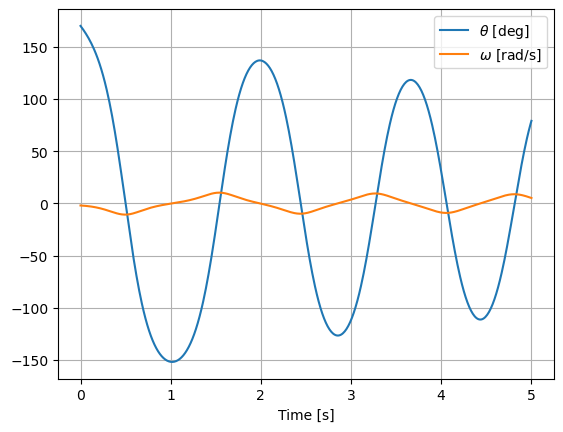

In [13]:
# ======================================================================
# Initialize the pendulum and compute a trajectory by simulating the ODE
# ======================================================================

# Initialize the true parameters of the pendulum
mass = 1.0
radius = 0.01
length = 0.500
friction = 0.010
body = Body.build(mass=mass, radius=radius, length=length, friction=friction)

# All simulations will be done in open loop.
# Bonus: if we introduce a PID controller, maybe we can optimize its gains by
#        minimizing a trajectory following error?
tau = 0.0

# Define the initial state of the pendulum
omega_0 = -2.0
theta_0 = jnp.deg2rad(170.0)
x0 = state = State.build(theta=theta_0, omega=omega_0)

# Define the time horizon used for numerical integration
t0 = 0.0
tf = 5.000
steps_per_second = 100
t = jnp.linspace(start=t0, stop=tf, num=int((tf - t0) * steps_per_second) + 1)

# Solve the ODE and compute the trajectory
trajectory = solve_ode(solver=solver, term=f_tx, x0=x0, t=t, body=body)

# Plot the trajectory
plt.plot(t, jnp.rad2deg(trajectory.theta), label=r"$\theta$ [deg]")
plt.plot(t, trajectory.omega, label=r"$\omega$ [rad/s]")
plt.grid()
plt.legend()
plt.xlabel("Time [s]")
plt.show()

## 4. Application 2: hardware optimization

Now, we want to (finally!) perform some optimization exploiting our **differentiable simulator**. Yes, what we've got in the previous steps is a simplified version of a rigid-body simulator developed entirely in Python.

With JAX, we have the possiblity to **get great runtime performance by compiling the simulator** in just-in-time, **execute it transparently on hardware accelerators** (GPUs, TPUs) without requiring any code change, and (advanced usage) scale the computation to **run in parallel instances** with a very small effort. Not bad.

Let's show case some of these JAX features by performing **hardware optimization**:

- We consider a problem in which we have some trajectories coming from a pendulum (it could be a real system, but in this example we use our simulator w/o gradients to generate a dataset with added noise).
- We assume to know the physics of the observed system (the differentiable simulator / forward model) considering as parameters all the attributes of the class `Body` (mass, radius, length, friction).
- We optimize with gradient descent the body parameters so that we (hopefully) converge to the parameters of the real pendulum that generated the trajectories.

A good starting point is defining a loss function. If $(\bar{\theta}, \bar{\omega})$ are the noisy trajectory of the dataset, we can define:

$$
\mathcal{L}(body) = \frac{1}{N+1} \sum_{k=0}^{N} \lVert \theta(k) - \bar{\theta}(k) \rVert^2 + \frac{1}{N+1} \sum_{k=0}^{N} \lVert \omega(k) - \bar{\omega}(k) \rVert^2
$$

In [14]:
# ==================================================
# Define the loss function for hardware optimization
# ==================================================

@functools.partial(jax.jit, static_argnames=["solver", "term"])
def loss_fn(
    parameters_opti: dict[str, Union[Body, jnp.ndarray, float]],
    trajectory_true: dict[str, Union[Body, jnp.ndarray, float]],
    x0: State,
    t: jnp.ndarray,
    solver: diffrax.AbstractSolver,
    term: diffrax.ODETerm,
) -> float:
    """Compute the loss function for pendulum parameters optimization."""

    # Use the optimized parameters to compute the trajectory
    trajectory_optimized = solve_ode(
        solver=solver, term=term, x0=x0, t=t, body=parameters_opti["body"]
    )

    # Compute the error between the true trajectory and the trajectory computed
    # using the optimized parameters
    return mean_squared_error(trajectory_true, trajectory_optimized)


def sample_trajectory(
    body: Body,
    x0: State,
    inject_noise: bool = False,
) -> Tuple[State, jnp.ndarray, diffrax.AbstractSolver, diffrax.ODETerm]:
    """Sample a trajectory starting from an initial state."""

    solver, f_tx = initialize_ode_solver()
    
    # Define the time horizon used for numerical integration
    t0 = 0.0
    tf = 5.0
    steps_per_second = 100
    t = jnp.linspace(start=t0, stop=tf, num=int((tf - t0) * steps_per_second) + 1)

    # Use the optimized parameters to compute the trajectory
    trajectory = solve_ode(
        solver=solver, term=f_tx, x0=x0, t=t, body=body
    )

    if not inject_noise:
        return trajectory, t, solver, f_tx

    # Initialize JAX random resources
    key = jax.random.PRNGKey(
        seed=jnp.array(body.mass * 1e6, dtype=int)
    )
    key_theta, key_omega = jax.random.split(key, num=2)

    # Add some noise
    trajectory_noisy = State.build(
        theta=trajectory.theta
        + jnp.deg2rad(10.0)
        * jax.random.normal(key=key_theta, shape=trajectory_true.theta.shape),
        omega=trajectory.omega
        + jnp.deg2rad(10.0)
        * jax.random.normal(key=key, shape=trajectory_true.omega.shape),
    )

    return trajectory_noisy, t, solver, f_tx


# Validate that loss=0 with real parameters, and loss≠0 with different parameters
x0 = State.build(theta=jnp.pi / 2, omega=0.0)
body1 = Body.build(mass=1.0, radius=0.01, length=0.500, friction=0.010)
body2 = Body.build(mass=100.0, radius=0.01, length=0.500, friction=0.010)
trajectory, t, solver, f_tx = sample_trajectory(body=body1, x0=x0, inject_noise=False)
assert jnp.allclose(0.0, loss_fn(dict(body=body1), trajectory, x0, t, solver, f_tx))
assert not jnp.allclose(0.0, loss_fn(dict(body=body2), trajectory, x0, t, solver, f_tx))

### Optional: validate the gradients

In [15]:
# Define an initial state
x0 = State.build(theta=jnp.pi / 2, omega=0.0)

# Define the real body and sample the real trajectory without noise
body_true = Body.build(mass=1.0, radius=0.01, length=0.500, friction=0.010)
trajectory_true, t, solver, f_tx = sample_trajectory(
    body=body_true, x0=x0, inject_noise=False,
)

# Define a body with different parameters (intermediate stage of learning)
body_optimized = Body.build(mass=100.0, radius=0.01, length=0.500, friction=0.010)

# Check the gradients w.r.t. finite differences
jax.test_util.check_grads(
    f=lambda param, traj, x0, t: loss_fn(param, traj, x0, t, solver, f_tx),
    args=(dict(body=body_optimized), trajectory_true, x0, t),
    order=1,
    eps=jnp.finfo(jnp.array(0.0, dtype=float)).resolution ** (1 / 3),
    modes=('rev'),  # diffrax integrators do not support 'fwd'?
)

In [16]:
# ====================================================================================
# Utility function to plot trajectories sampled from the real and optimized parameters
# ====================================================================================

def plot(params_true: dict, params_opti: dict, x0: State, t: jnp.ndarray) -> None:
    """Plot the true and optimized trajectories."""

    # Compute the true trajectory
    trajectory_true = solve_ode(
        solver=solver, term=f_tx, x0=x0, t=t, body=params_true["body"]
    )

    # Compute the optimized trajectory
    trajectory_opti = solve_ode(
        solver=solver, term=f_tx, x0=x0, t=t, body=params_opti["body"]
    )

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)  # noqa

    ax1.plot(t, jnp.rad2deg(trajectory_true.theta), label="true")
    ax1.plot(
        t, jnp.rad2deg(trajectory_opti.theta), linestyle="--", label="optimized"
    )
    ax1.set_title(r"Pendulum angle")
    ax1.set_ylabel(r"$\theta$ [deg]")
    ax1.legend()
    ax1.grid()

    ax2.plot(t, trajectory_true.omega, label="true")
    ax2.plot(t, trajectory_opti.omega, linestyle="--", label="optimized")
    ax2.set_title(r"Pendulum angular velocity")
    ax2.set_xlabel("time [s]")
    ax2.set_ylabel(r"$\omega$ [deg/s]")
    ax2.legend()
    ax2.grid()

    # Not necessary in a jupyter notebook
    # fig.show()

### Optimize

**Initial state x0:**

State(theta=Array(1.5708, dtype=float64), omega=Array(3., dtype=float64))


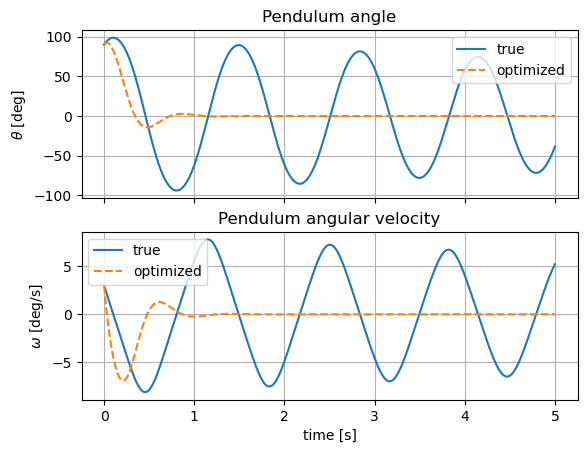

In [18]:
# =============================================================================================
# Define the real (true) parameters, and initialize the optimized parameters far away from them
# =============================================================================================

# Initialize the true parameters to which we would like to converge
parameters_true = dict(body=body)

# Initialize the optimization parameters far away from the true ones
parameters = dict(
    body=Body.build(
        mass=body.mass * 2.0,
        length=body.length * 0.2,
        radius=body.radius * 10.0,
        friction=friction * 10.0,
    ),
)

# Define the initial state of the pendulum
omega_0 = 3.0
theta_0 = jnp.deg2rad(90.0)
x0 = State.build(theta=theta_0, omega=omega_0)

display(Markdown("**Initial state x0:**"))
print(x0)

# Plot the trajectory with the initial parameters to visualize that it is
# considerably different w.r.t. the true trajectory
plot(params_true=parameters_true, params_opti=parameters, x0=x0, t=t)

In [19]:
# Create and initialize the ADAM optimizer
learning_rate = 0.003_500
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(parameters)

# Define an initial state
x0 = State.build(theta=jnp.pi / 2, omega=2.0)
trajectory_true, t, solver, f_tx = sample_trajectory(
    body=parameters_true["body"], x0=x0, inject_noise=True
)

# JIT-compile the function to compute the loss gradient.
# We need to operate on a closure that only expose types that JAX supports.
value_and_grad_loss_fn = jax.jit(jax.value_and_grad(
    lambda parameters, trajectory_true, x0: loss_fn(
        parameters, trajectory_true, x0, t, solver, f_tx
    ), 
    argnums=0, 
    has_aux=False,
    )
)

# Training loop
for idx in range(1_000):

    # Compute the value of the loss function and the gradient w.r.t. the optimized parameters
    loss, grads = value_and_grad_loss_fn(parameters, trajectory_true, x0)
    
    # Use the gradients to optimize the parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    parameters = optax.apply_updates(parameters, updates)

    if idx % 25 != 0:
        continue

    print(
        f"#{idx:04d}"
        + f"|log(loss)={float(jnp.log(loss)):.5f}"
        + f"|mass={parameters['body'].mass:.3f}_({body.mass:.3f})"
        + f"|length={parameters['body'].length:.3f}_({body.length:.3f})"
        + f"|radius={parameters['body'].radius:.3f}_({body.radius:.3f})"
        + f"|friction={parameters['body'].friction:.4f}_({body.friction:.4f})"
    )

#0000|log(loss)=2.42386|mass=1.993_(1.000)|length=0.100_(0.500)|radius=0.100_(0.010)|friction=0.1004_(0.0100)
#0025|log(loss)=2.38353|mass=1.831_(1.000)|length=0.091_(0.500)|radius=0.110_(0.010)|friction=0.1092_(0.0100)
#0050|log(loss)=2.35783|mass=1.713_(1.000)|length=0.085_(0.500)|radius=0.120_(0.010)|friction=0.1168_(0.0100)
#0075|log(loss)=2.34390|mass=1.655_(1.000)|length=0.081_(0.500)|radius=0.132_(0.010)|friction=0.1208_(0.0100)
#0100|log(loss)=2.33209|mass=1.658_(1.000)|length=0.079_(0.500)|radius=0.145_(0.010)|friction=0.1206_(0.0100)
#0125|log(loss)=2.31422|mass=1.714_(1.000)|length=0.078_(0.500)|radius=0.161_(0.010)|friction=0.1167_(0.0100)
#0150|log(loss)=2.27961|mass=1.832_(1.000)|length=0.077_(0.500)|radius=0.182_(0.010)|friction=0.1092_(0.0100)
#0175|log(loss)=2.19677|mass=2.061_(1.000)|length=0.077_(0.500)|radius=0.211_(0.010)|friction=0.0970_(0.0100)
#0200|log(loss)=1.98722|mass=2.475_(1.000)|length=0.088_(0.500)|radius=0.243_(0.010)|friction=0.0808_(0.0100)
#0225|log(

**Initial state x0:**

State(theta=Array(2.96706, dtype=float64), omega=Array(0., dtype=float64))


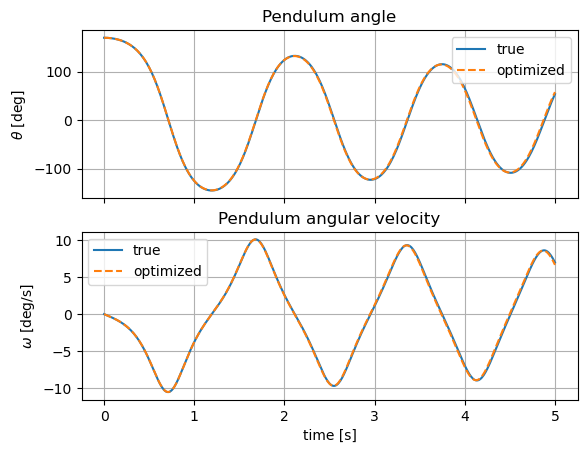

In [20]:
# Define the initial state of the pendulum
omega_0 = 0.0
theta_0 = jnp.deg2rad(170.0)
x0 = state = State.build(theta=theta_0, omega=omega_0)

display(Markdown("**Initial state x0:**"))
print(x0)

plot(params_true=parameters_true, params_opti=parameters, x0=x0, t=t)

- Did it work?
- Are you sure? Check the optimized parameters.
- Can you think the reasons why we obtained this result?
- Try to change the parameters initialization, does the outcome change?
- Can you think of how to obtain the correct parameters?
  - Reducing the number of parameters?
  - Include more physical phenomena in the loss function?
  - ...

## Final thoughts

- What we've done in Application 2 is basically **supervised learning**! Instead of having a neural network acting as a generic function approximation exposing neuron parameters, we used physics equations exposing some of its parameters. Then, we applied regular gradient descent to minimizing a loss function.
- What we've obtained in Application 1 is a rigid-body simulator from which we can sample trajectories. It turns out that this is extremely useful in **reinforcement learning** applications! We have only seen how to sample a trajectory starting from a single $\mathbf{x}_0$, but we can use `jax.vmap` to sample concurrently hundred or thousand of trajectories from different initial conditions on hardware acceleratos.
- Beyond hardware optimization, we can use the differentiable simulator and generally JAX for many other robot learning applications, for example:
  - **reinforced imitation learning**: sample simulated trajectories and learn a controller using expert / imitation / retargeted trajectory in the reward function.
  - **supervised imitation learning**: start from pre-recorded / retargeted trajectories and use automatic differentiation to learn an optimal controller with a supervised approach (or, offline RL).
  - ...

---

Interesting libraries that can be useful for our applications:

- [`n2cholas/awesome-jax`](https://github.com/n2cholas/awesome-jax): JAX - A curated list of resources.
- [`brentyi/jaxlie`](https://github.com/brentyi/jaxlie): Rigid-body transformations based on Lie groups.
- [`deepmind/optax`](https://github.com/deepmind/optax): Gradient processing and optimization library.
- [`google/jaxopt`](https://github.com/google/jaxopt): Hardware accelerated, batchable and differentiable optimizers in JAX.
- [`patrick-kidger/diffrax`](https://github.com/patrick-kidger/diffrax): Numerical differential equation solvers in JAX. Autodifferentiable and GPU-capable.
- [`patrick-kidger/equinox`](https://github.com/patrick-kidger/equinox): Neural network in JAX.
- [`brentyi/jax_dataclasses`](https://github.com/brentyi/jax_dataclasses): Implement PyTrees objects with `dataclasses`.
- [`google/brax`](https://github.com/google/brax): Massively parallel rigid-body physics simulation on accelerator hardware.
- [`ami-iit/jaxsim`](https://github.com/ami-iit/jaxsim): A scalable physics engine implemented with JAX.

## Additional resources

- [Using JAX to accelerate our research](https://www.deepmind.com/blog/using-jax-to-accelerate-our-research)
- [Simulation Intelligence: Towards a New Generation of Scientific Methods](https://arxiv.org/pdf/2112.03235.pdf)
- [Scientific Machine Learning Through Physics–Informed Neural Networks: Where we are and What’s Next](https://link.springer.com/10.1007/s10915-022-01939-z)
- [∂P: A Differentiable Programming System to Bridge Machine Learning and Scientific Computing](http://arxiv.org/abs/1907.07587)
- [JAX vs Julia (vs PyTorch)](https://kidger.site/thoughts/jax-vs-julia/)
- [Why You Should (or Shouldn't) be Using Google's JAX in 2023](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2023/)
- [Need for Speed: JAX](https://blog.ml6.eu/need-for-speed-jax-1d203d434718)